### Import Libraries 

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import scipy.stats as sst
import seaborn as sns
import statsmodels.api as sm
from pandas_datareader.famafrench import get_available_datasets

### Import ETF data from Yahoo Finance

In [2]:
tickers = ['SPY', 'IEUR', 'AIA']

ETFs = pd.DataFrame()

for t in tickers:
    ETFs[t] = pdr.DataReader(t, data_source = 'yahoo', start = '2014-1-1', end = '2021-12-31')['Adj Close']

In [3]:
ETFs_return = ETFs/ETFs.shift(1) - 1
ETFs_return = ETFs_return.dropna()
ETFs_return.head()

,SPY,IEUR,AIA
Date,,,
2014-06-13,0.003049,-0.000801,0.002689
2014-06-16,0.000824,-0.004809,-0.002269
2014-06-17,0.002779,0.000000,0.001447
2014-06-18,0.007340,0.015301,0.005780
2014-06-19,0.001121,0.001547,-0.005131


### Descriptive Statistics And Graphs

In [4]:
ETFs_return.describe()

,SPY,IEUR,AIA
count,1903.000000,1903.000000,1903.000000
mean,0.000608,0.000260,0.000412
std,0.010890,0.011633,0.012973
min,-0.109424,-0.116541,-0.098266
25%,-0.003116,-0.004591,-0.006628
50%,0.000659,0.000632,0.000851
75%,0.005372,0.006050,0.007914
max,0.090603,0.091052,0.069101


In [5]:
ETFs_return.mean()*250

SPY     0.151952
IEUR    0.064894
AIA     0.102876
dtype: float64

#### The mean daily and annual return on “SPY” is more than double of “IEUR” and 1.47 more of “AIA”

### Figure 1

<AxesSubplot:xlabel='Date'>

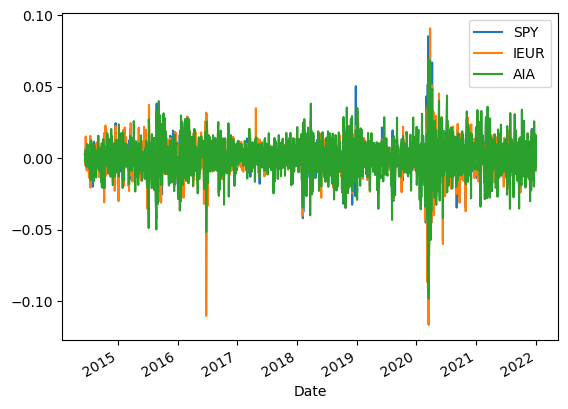

In [6]:
ETFs_return.plot()

#### 1. Fluctuations of the daily returns of the three ETFs are relatively similar, centered between 0.05 and -0.05

#### 2. Major fluctuations occurred between 2020 and 2021 which is during the Covid-19 period

### Figure 2 (Kernel Density Estimation Plot)

<AxesSubplot:ylabel='Density'>

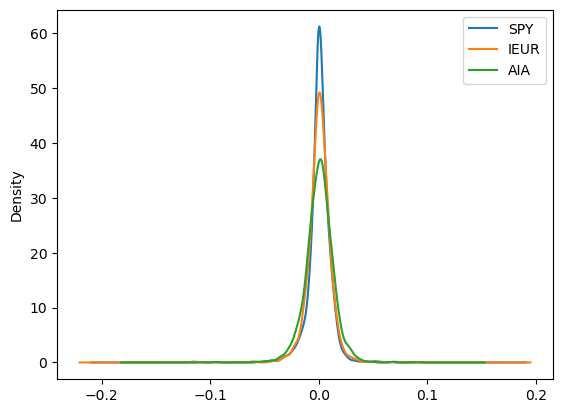

In [7]:
ETFs_return.plot(kind = 'kde')

#### SPY has an overall higher and centered return than IEUR and AIA

### Standard Deviation (Measure Risks)

In [8]:
ETFs_return.std()

SPY     0.010890
IEUR    0.011633
AIA     0.012973
dtype: float64

### Correlation 

In [9]:
corr_matrix = ETFs_return.corr()
corr_matrix

,SPY,IEUR,AIA
SPY,1.000000,0.837054,0.720150
IEUR,0.837054,1.000000,0.726406
AIA,0.720150,0.726406,1.000000


<AxesSubplot:>

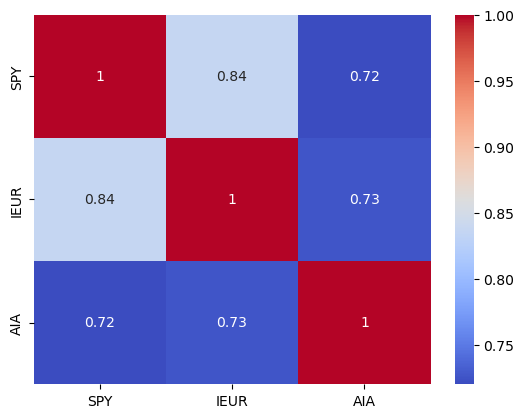

In [10]:
corr = ETFs_return.corr()

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "coolwarm")

#### All 3 ETFs are highly correlated (move in the same direction)

### Spearman rank correlation test

In [11]:
sst.pearsonr(ETFs_return['SPY'], ETFs_return['IEUR'])

PearsonRResult(statistic=0.8370535363916326, pvalue=0.0)

In [12]:
sst.pearsonr(ETFs_return['SPY'], ETFs_return['AIA'])

PearsonRResult(statistic=0.7201504500701316, pvalue=4.097287930948629e-304)

#### Reject the null hypothesis and that the correlations are statistically different from zero

### Portfolio Analysis 

#### Hypothesis Test (Return):
- H0: u1 = u2 --> null hypothesis
- Ha: u1 ≠ u2 --> alternative hypothesis 

In [13]:
weights1 = np.array([0.33,0.33,0.33])

port_ret1 = np.dot(ETFs_return, weights1)
port_ret1 = port_ret1[~np.isnan(port_ret1)]
port_ret1

array([ 0.00162898, -0.00206372,  0.0013947 , ..., -0.00069854,
        0.00320236, -0.00383666])

In [14]:
weights2 = np.array([0.21,0.43,0.37])

port_ret2 = np.dot(ETFs_return, weights2)
port_ret2 = port_ret2[~np.isnan(port_ret2)]
port_ret2

array([ 0.00129061, -0.00273429,  0.00111907, ..., -0.00088517,
        0.0037936 , -0.00393971])

In [15]:
sst.ttest_ind(a = port_ret1, b = port_ret2, equal_var = False)

Ttest_indResult(statistic=0.08625464257087727, pvalue=0.9312685387094951)

#### Fail to reject the null hypothesis; the mean return of the 2 portfolios are not statistically different

#### Hypothesis Test (Risks):
- H0: u1 = u2 --> null hypothesis
- Ha: u1 ≠ u2 --> alternative hypothesis 

In [16]:
F_stat = max(port_ret1.var()/port_ret2.var(),
             port_ret2.var()/port_ret1.var())
F_stat

1.0697154485065492

In [17]:
sst.f.ppf(0.95, dfn = 1902, dfd = 1902)

1.0783695556722634

In [18]:
p_value1 = 1 - sst.f.cdf(F_stat, dfn = 1902, dfd = 1902)
p_value1

0.07088519928504344

#### Fail to reject the null hypothesis; the variance of the 2 portfolios are not statistically different

### Economic Significance

#### Return:

In [19]:
a = float((ETFs_return['SPY'][1902] - ETFs_return['SPY'][0]) / ETFs_return['SPY'][0] * 100)
b = float((ETFs_return['IEUR'][1902] - ETFs_return['IEUR'][0]) / ETFs_return['IEUR'][0] * 100)
c = float((ETFs_return['AIA'][1902] - ETFs_return['AIA'][0]) / ETFs_return['AIA'][0] * 100)

In [20]:
df = {'ETF':['SPY', 'IEUR', 'AIA'], 'Cumulative_Return':[a, b, c]}
pd.DataFrame(df)

,ETF,Cumulative_Return
0,SPY,-182.670176
1,IEUR,-14.176350
2,AIA,-413.127002


#### Risk:

In [21]:
Sr = (ETFs_return.mean()*250 - 0.03)/ (ETFs_return.std()*(250**0.5))
Sr

SPY     0.708261
IEUR    0.189717
AIA     0.355279
dtype: float64

#### Explanation: 
- Positive value = Positive excess return for each unit of risk
- Less than 1 = suboptimal (low excess return, esp for IEUR and AIA)

### Portfolio Return and Risks:

In [22]:
port1 = np.array([0.33,0.33,0.33]) #Equal weight
port2 = np.array([0.21,0.43,0.37]) #Diversified

In [23]:
def port_rr(port):
    return np.dot(ETFs_return,port)

df = pd.DataFrame({'Portfolio':['1','2'],'Mean Return':[port_rr(port1).mean()*250, port_rr(port2).mean()*250], 'Standard Deviation':[(port_rr(port1).var()*250)**0.5, (port_rr(port2).var()*250)**0.5]}, index=['1','2'])
df = df.set_index('Portfolio')
pd.DataFrame(df)

,Mean Return,Standard Deviation
Portfolio,,
1,0.105508,0.169593
2,0.097878,0.175405


In [24]:
def port_sr(port):
    return np.dot(ETFs_return,port)

df = pd.DataFrame({'Portfolio':['1','2'],'Sharpe Ratio':[(port_rr(port1).mean()*250 - 0.03)/(port_rr(port1).std()*(250**0.5)), (port_rr(port2).mean()*250 - 0.03)/ (port_rr(port2).std()*(250**0.5))]},index=['1','2'])
df = df.set_index('Portfolio')
pd.DataFrame(df)

,Sharpe Ratio
Portfolio,
1,0.445231
2,0.386981


#### Explanation:
#### Portfolio with equal weight peformed better than diverfisifed portfolio. However, the computation of different weights on each ETF will make a difference.
#### E.g. More weight on SPY will yield higher return
#### Note: The risk in standard deviation has been consistent (no significant increase)

### CAPM Model

In [25]:
tickers1 = ['SPY', 'IEUR', 'AIA', '^IRX']

etfs = pd.DataFrame()

for t in tickers1:
    etfs[t] = pdr.DataReader(t, data_source = 'yahoo', start = '2014-1-1', end = '2021-12-31')['Adj Close']

In [26]:
etfs_returns = (etfs/etfs.shift(1))-1
etfs_returns['^IRX'] = etfs['^IRX']/(100*250)
etfs_returns = etfs_returns.dropna(axis = 0, how = 'any')
etfs_returns.head()

,SPY,IEUR,AIA,^IRX
Date,,,,
2014-06-13,0.003048,-0.000801,0.002689,1.200000e-06
2014-06-16,0.000825,-0.004809,-0.002269,1.000000e-06
2014-06-17,0.002779,0.000000,0.001447,1.320000e-06
2014-06-18,0.007340,0.015301,0.005780,7.200000e-07
2014-06-19,0.001121,0.001546,-0.005131,4.000000e-07


In [27]:
X1 = sm.add_constant(etfs_returns['SPY'] - etfs_returns['^IRX'])
X1

,const,0
Date,,
2014-06-13,1.0,0.003047
2014-06-16,1.0,0.000824
2014-06-17,1.0,0.002778
2014-06-18,1.0,0.007339
2014-06-19,1.0,0.001121
...,...,...
2021-12-27,1.0,0.014150
2021-12-28,1.0,-0.000819
2021-12-29,1.0,0.001277


#### IEUR Regression

In [28]:
reg1 = sm.OLS(etfs_returns['IEUR']- etfs_returns['^IRX'], X1).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     4448.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:36:47   Log-Likelihood:                 6916.2
No. Observations:                1901   AIC:                        -1.383e+04
Df Residuals:                    1899   BIC:                        -1.382e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.927      0.054      -0.001    5.06e-06
0              0.8941      0.013     66.692      0.000       0.868       0.920
==============================================================================
Omnibus:                      611.716   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13959.930
Skew:                          -0.966   Prob(JB):                         0.00
Kurtosis:                      16.134   Cond. No.                         91.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Explanation

- 70.1% systematic risk / 29.9% idiosyncrastic risk
- Negative alpha but marginal
- Beta < 1 = IEUR < Market systematic risk

- Fail to reject the hypothesis that the coefficient is equal to zero; the alpha of “IEUR” is not statistically different from zero

- Reject the null hypothesis for beta that the coeffecients are equal to zero

- Economically, IEUR performed slightly worse than the CAPM predicted during the sample period

#### AIA Regression

In [29]:
reg2 = sm.OLS(etfs_returns['AIA'] - etfs_returns['^IRX'], X1).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     2046.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):          8.63e-304
Time:                        00:36:47   Log-Likelihood:                 6256.9
No. Observations:                1901   AIC:                        -1.251e+04
Df Residuals:                    1899   BIC:                        -1.250e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.542      0.588      -0.001       0.000
0              0.8578      0.019     45.231      0.000       0.821       0.895
==============================================================================
Omnibus:                      102.770   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.362
Skew:                           0.112   Prob(JB):                     6.22e-81
Kurtosis:                       5.148   Cond. No.                         91.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 51.9% systematic risk / 48.1% idiosyncrastic risk
- Negative alpha but extremely marginal
- Beta < 1 = IEUR < Market systematic risk

- Fail to reject the hypothesis that the coefficient is equal to zero; the alpha of “IEUR” is not statistically different from zero

- Reject the null hypothesis for beta that the coeffecients are equal to zero

- Economically, AIA performed slightly worse than the CAPM predicted during the sample period

### 4 Factor Model

In [30]:
ff = pdr.DataReader('F-F_Research_Data_Factors_daily','famafrench', start = '2014-6-13', end = '2021-12-31')[0]
mm = pdr.DataReader('F-F_Momentum_Factor_daily','famafrench', start = '2014-6-13', end = '2021-12-31')[0]
mm.columns=['Mom']
factors = pd.merge(ff,mm,left_index=True,right_index=True)

In [31]:
all = pd.merge(ETFs_return,factors,left_index=True,right_index=True)
all = all.dropna(axis = 0, how = 'any')
all.head()

,SPY,IEUR,AIA,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,,,,
2014-06-13,0.003049,-0.000801,0.002689,0.31,-0.06,-0.18,0.0,-0.08
2014-06-16,0.000824,-0.004809,-0.002269,0.13,0.47,-0.69,0.0,0.10
2014-06-17,0.002779,0.000000,0.001447,0.34,0.54,0.46,0.0,-0.06
2014-06-18,0.007340,0.015301,0.005780,0.75,-0.26,-0.09,0.0,0.09
2014-06-19,0.001121,0.001547,-0.005131,0.12,-0.15,-0.04,0.0,0.11


In [32]:
sec_beta = pd.DataFrame(np.nan,index=tickers,columns=['const','Mkt-RF','SMB','HML','Mom'])
sec_beta

,const,Mkt-RF,SMB,HML,Mom
SPY,NaN,NaN,NaN,NaN,NaN
IEUR,NaN,NaN,NaN,NaN,NaN
AIA,NaN,NaN,NaN,NaN,NaN


In [33]:
for t in tickers:
    X = all[['Mkt-RF','SMB','HML','Mom']]
    X1 = sm.add_constant(X)
    Y = all[t] - all['RF']
    reg = sm.OLS(Y,X1).fit()
    sec_beta.loc[t,:]=reg.params
sec_beta

,const,Mkt-RF,SMB,HML,Mom
SPY,-0.002768,0.009781,-0.001192,0.000265,-0.000113
IEUR,-0.003022,0.008603,0.000109,0.001404,-0.000588
AIA,-0.002910,0.008476,0.000406,-0.000974,-0.000491


#### Explanation

- Constant: pos: outperfomed / neg: underperformed than market
- SMB: pos: small cap (IEUR, AIA) / neg: large cap (SPY) /
- HML: pos: value stocks (SPY, IEUR) / neg: growth stock (AIA)
- Mom: pos: momentum stock / neg: X momentum stock

### Portfolio sort

- Sort trading days according to trading volumes of all ETFs and examines their return differences between high volume days and low volume days

- Separated into quintiles, with 0 being the lowest trading volume, and 4 being the highest

In [34]:
SPY = pdr.DataReader('SPY',data_source='yahoo',start = '2014-1-1', end = '2021-12-31')[['Adj Close','Volume']]

In [35]:
SPY['return'] = SPY['Adj Close']/SPY['Adj Close'].shift(1)-1
SPY = SPY.dropna(axis=0, how='any')
SPY.head()

,Adj Close,Volume,return
Date,,,
2014-01-03,155.675735,81390600.0,-0.000164
2014-01-06,155.224594,108028200.0,-0.002898
2014-01-07,156.177887,86144200.0,0.006141
2014-01-08,156.211914,96582300.0,0.000218
2014-01-09,156.314087,90683400.0,0.000654


In [36]:
SPY['rank']=pd.DataFrame(pd.qcut(SPY['Volume'],5,labels=False))
SPY.head()

,Adj Close,Volume,return,rank
Date,,,,
2014-01-03,155.675735,81390600.0,-0.000164,2
2014-01-06,155.224594,108028200.0,-0.002898,3
2014-01-07,156.177887,86144200.0,0.006141,2
2014-01-08,156.211914,96582300.0,0.000218,3
2014-01-09,156.314087,90683400.0,0.000654,3


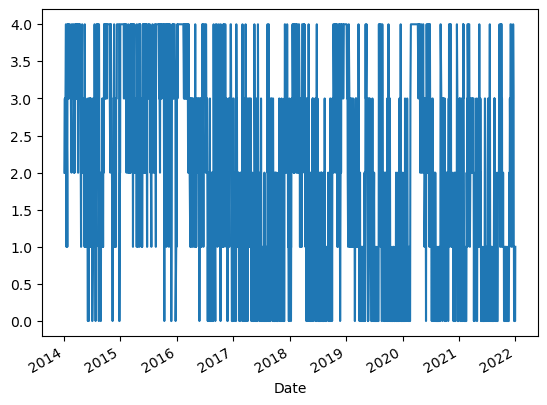

In [37]:
SPY['rank'].plot()
plt.show()

In [38]:
port=pd.DataFrame()
for rank in [0,1,2,3,4]:
    print(rank)
    temp=SPY['return'][SPY['rank']==rank]
    temp=temp.reset_index(drop=True)
    port=port.reset_index(drop=True)
    port=pd.concat([port,temp],axis=1,ignore_index=True)
port=port.dropna(axis=0, how='any')

0
1
2
3
4


In [39]:
port.head()

,0,1,2,3,4
0,0.002023,-0.001300,-0.000164,-0.002898,-0.013305
1,0.000102,0.000652,0.006141,0.000218,-0.008193
2,0.001015,0.003487,0.002940,0.000654,-0.021336
3,0.004918,0.000896,0.001196,0.002723,-0.004919
4,0.000050,-0.004738,0.000906,0.010898,-0.009606


In [40]:
for i in [0,1,2,3,4]:
    print(i)
    print(port.loc[:,i].mean())
    print(sst.ttest_1samp(a=port.loc[:,i],popmean=0))    

0
0.0017880950767813191
Ttest_1sampResult(statistic=9.604575037466876, pvalue=8.520367448815725e-20)
1
0.002001800262862028
Ttest_1sampResult(statistic=7.4465037357494355, pvalue=5.921023632274815e-13)
2
0.0013503501293108604
Ttest_1sampResult(statistic=4.478863126790673, pvalue=9.798578403866418e-06)
3
0.0012175857084053647
Ttest_1sampResult(statistic=2.7731367674985927, pvalue=0.0058109948423779355)
4
-0.0032565897572691665
Ttest_1sampResult(statistic=-3.2704730491140155, pvalue=0.001166474257946979)


#### For “SPY”, we are able to reject the null hypothesis of all 5 groups that the mean returns are statistically significant from zero for each group

In [41]:
sst.ttest_rel(a=port.loc[:,4],b=port.loc[:,0])

Ttest_relResult(statistic=-4.8809136268060245, pvalue=1.5269201809111843e-06)

#### “SPY”’s highest return group is statistically different from the lowest return group

In [42]:
IEUR = pdr.DataReader('IEUR',data_source='yahoo',start = '2014-1-1', end = '2021-12-31')[['Adj Close','Volume']]

In [43]:
IEUR['return'] = IEUR['Adj Close']/IEUR['Adj Close'].shift(1)-1
IEUR = IEUR.dropna(axis=0, how='any')
IEUR.head()

,Adj Close,Volume,return
Date,,,
2014-06-13,39.513950,2600.0,-0.000801
2014-06-16,39.323936,1000.0,-0.004809
2014-06-17,39.323936,1500.0,0.000000
2014-06-18,39.925640,25700.0,0.015301
2014-06-19,39.987381,14700.0,0.001546


In [44]:
IEUR['rank']=pd.DataFrame(pd.qcut(IEUR['Volume'],5,labels=False))
IEUR.head()

,Adj Close,Volume,return,rank
Date,,,,
2014-06-13,39.513950,2600.0,-0.000801,0
2014-06-16,39.323936,1000.0,-0.004809,0
2014-06-17,39.323936,1500.0,0.000000,0
2014-06-18,39.925640,25700.0,0.015301,0
2014-06-19,39.987381,14700.0,0.001546,0


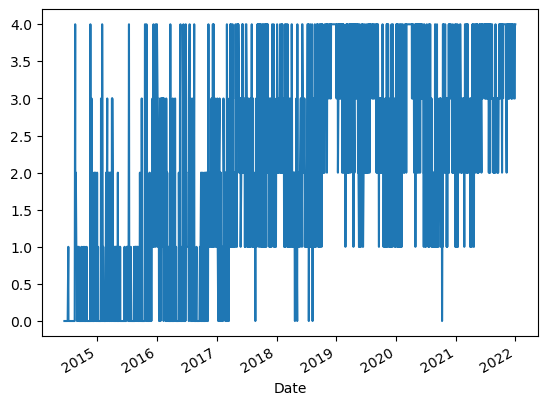

In [45]:
IEUR['rank'].plot()
plt.show()

In [46]:
port=pd.DataFrame()
for rank in [0,1,2,3,4]:
    print(rank)
    temp=IEUR['return'][IEUR['rank']==rank]
    temp=temp.reset_index(drop=True)
    port=port.reset_index(drop=True)
    port=pd.concat([port,temp],axis=1,ignore_index=True)
port=port.dropna(axis=0, how='any')

0
1
2
3
4


In [47]:
port.head()

,0,1,2,3,4
0,-0.000801,-0.011704,-0.003564,0.001951,0.009968
1,-0.004809,0.001680,-0.008157,-0.004976,0.000220
2,0.000000,0.005891,-0.022646,-0.000643,-0.011009
3,0.015301,0.011177,-0.000564,-0.016220,0.003899
4,0.001546,0.002086,-0.004746,0.009479,-0.004744


In [48]:
for i in [0,1,2,3,4]:
    print(i)
    print(port.loc[:,i].mean())
    print(sst.ttest_1samp(a=port.loc[:,i],popmean=0))    

0
0.000326791134092275
Ttest_1sampResult(statistic=0.6717248360865667, pvalue=0.5021681221815009)
1
0.0005157697829500084
Ttest_1sampResult(statistic=1.146679905838488, pvalue=0.252237344920076)
2
0.00042799648573451586
Ttest_1sampResult(statistic=0.8806968425921797, pvalue=0.3790400531065562)
3
0.000355392954186642
Ttest_1sampResult(statistic=0.7372017245232555, pvalue=0.4614558120081248)
4
-0.00035315888491482963
Ttest_1sampResult(statistic=-0.3769966381546001, pvalue=0.7063870967571111)


#### For “IEUR”, we fail to reject the null hypothesis of all 5 groups that none of them are statistically different

In [49]:
sst.ttest_rel(a=port.loc[:,4],b=port.loc[:,0])

Ttest_relResult(statistic=-0.6625026422359211, pvalue=0.5080518080078023)

#### “IEUR”’s highest return group is NOT statistically different from the lowest return group

In [50]:
AIA = pdr.DataReader('AIA',data_source='yahoo',start = '2014-1-1', end = '2021-12-31')[['Adj Close','Volume']]

In [51]:
AIA['return'] = AIA['Adj Close']/AIA['Adj Close'].shift(1)-1
AIA = AIA.dropna(axis=0, how='any')
AIA.head()

,Adj Close,Volume,return
Date,,,
2014-01-03,38.950317,32900.0,-0.007735
2014-01-06,38.638248,49500.0,-0.008012
2014-01-07,38.705715,31800.0,0.001746
2014-01-08,38.806934,7000.0,0.002615
2014-01-09,38.503304,19400.0,-0.007824


In [52]:
AIA['rank']=pd.DataFrame(pd.qcut(AIA['Volume'],5,labels=False))
AIA.head()

,Adj Close,Volume,return,rank
Date,,,,
2014-01-03,38.950317,32900.0,-0.007735,1
2014-01-06,38.638248,49500.0,-0.008012,2
2014-01-07,38.705715,31800.0,0.001746,1
2014-01-08,38.806934,7000.0,0.002615,0
2014-01-09,38.503304,19400.0,-0.007824,1


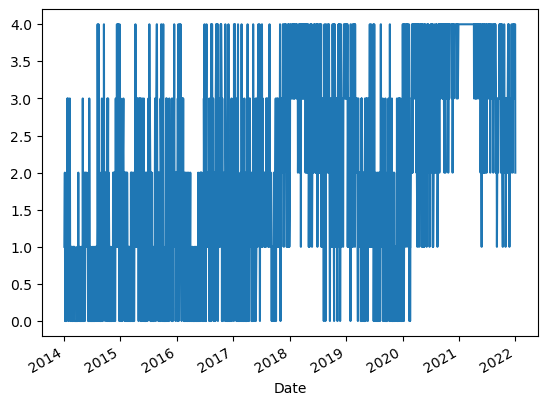

In [53]:
AIA['rank'].plot()
plt.show()

In [54]:
port.head()

,0,1,2,3,4
0,-0.000801,-0.011704,-0.003564,0.001951,0.009968
1,-0.004809,0.001680,-0.008157,-0.004976,0.000220
2,0.000000,0.005891,-0.022646,-0.000643,-0.011009
3,0.015301,0.011177,-0.000564,-0.016220,0.003899
4,0.001546,0.002086,-0.004746,0.009479,-0.004744


In [55]:
port=pd.DataFrame()
for rank in [0,1,2,3,4]:
    print(rank)
    temp=AIA['return'][AIA['rank']==rank]
    temp=temp.reset_index(drop=True)
    port=port.reset_index(drop=True)
    port=pd.concat([port,temp],axis=1,ignore_index=True)
port=port.dropna(axis=0, how='any')

0
1
2
3
4


In [56]:
for i in [0,1,2,3,4]:
    print(i)
    print(port.loc[:,i].mean())
    print(sst.ttest_1samp(a=port.loc[:,i],popmean=0))   

0
0.0004830566271314943
Ttest_1sampResult(statistic=1.151490088952854, pvalue=0.2502167592969644)
1
0.0007955062120729847
Ttest_1sampResult(statistic=1.5820016684489706, pvalue=0.11443755721445803)
2
0.0012630722825138498
Ttest_1sampResult(statistic=2.252657274036127, pvalue=0.024820754613603325)
3
-0.00011368014674553023
Ttest_1sampResult(statistic=-0.16109310106200034, pvalue=0.8721012009003233)
4
-0.0003614688634419829
Ttest_1sampResult(statistic=-0.40794918566979965, pvalue=0.683528704095404)


#### For “AIA”, we are able to reject the null hypothesis for group 3 but not 1, 2, 4 and 5

In [57]:
sst.ttest_rel(a=port.loc[:,4],b=port.loc[:,0])

Ttest_relResult(statistic=-0.8895535951178806, pvalue=0.3742389668646027)

#### “AIA”’s highest return group is NOT statistically different from the lowest return group

### Limitations

#### Kurtosis:

In [58]:
ETFs_return.kurtosis()

SPY     17.568099
IEUR    19.906475
AIA      4.857862
dtype: float64

#### This might overestimate and underestimate the return and risks considering the inclusion of extreme outcomes

END